Mounting google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import fnmatch
import os
import keras
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, History, ReduceLROnPlateau, CSVLogger
from keras.metrics import*
from keras.models import*
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import time
from tqdm import tqdm_notebook as tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.manifold import TSNE
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from keras.applications.inception_v3 import InceptionV3
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
import datetime as dt
import h5py

Load Data

In [4]:
path = "/content/drive/MyDrive/plant-seedlings-classification/train/"
label_nums = {'Loose Silky-bent':0, 'Charlock':1, 'Sugar beet':2, 'Small-flowered Cranesbill':3,'Common Chickweed':4, 'Common wheat':5, 
             'Maize':6, 'Cleavers':7, 'Scentless Mayweed':8,'Fat Hen':9, 'Black-grass':10, 'Shepherds Purse':11}


In [ ]:
train_label = []
train_img = []

for i in os.listdir(path):
    label_number = label_nums[i]
    new_path = path+i+'/'
    for j in fnmatch.filter(os.listdir(new_path), '*.png'):
        temp_img = keras.preprocessing.image.load_img(new_path+j, target_size=(128,128))
        temp_img = keras.preprocessing.image.img_to_array(temp_img)
        train_img.append(temp_img)
        train_label.append(label_number)

train_img = np.array(train_img)

One Hot Encoding

In [6]:
train_label=np.array(pd.get_dummies(train_label))
print(train_img.shape)
print(train_label.shape)

(4760, 128, 128, 3)
(4760, 12)


Seeing how data is distributed

In [7]:
categories = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
dict1={}
for i in categories:
  dict1[i]=len(os.listdir(os.path.join(path, i)))
  print(i,dict1[i])

Black-grass 263
Charlock 390
Cleavers 287
Common Chickweed 611
Common wheat 221
Fat Hen 475
Loose Silky-bent 654
Maize 221
Scentless Mayweed 516
Shepherds Purse 231
Small-flowered Cranesbill 506
Sugar beet 385


Data for each category has varying number of images, where loos silky bent category has 654 images and maize has only 221 images 

Normalising 

In [8]:
train_img = train_img/255

**Visualising sample Images of 12 categories**

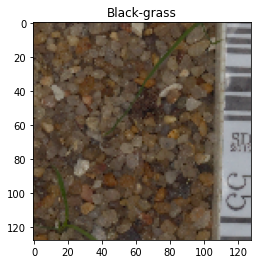

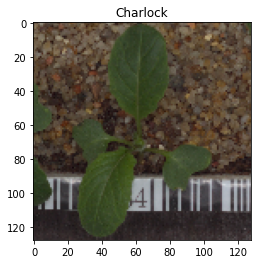

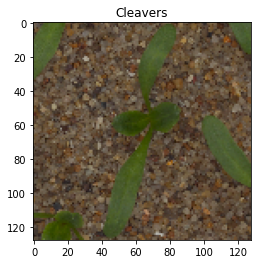

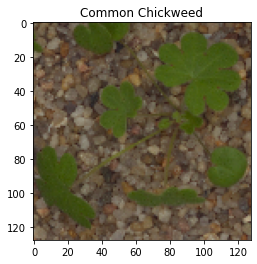

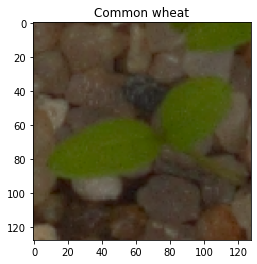

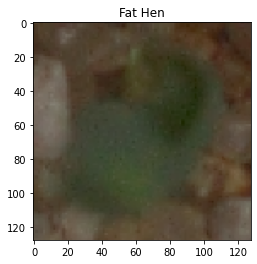

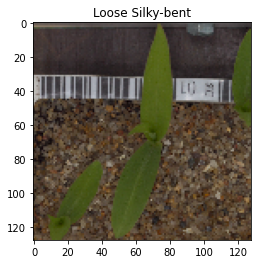

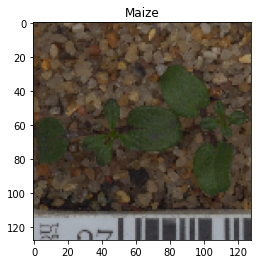

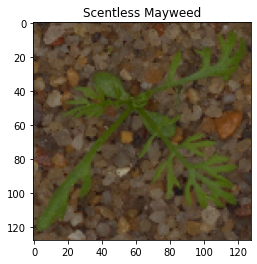

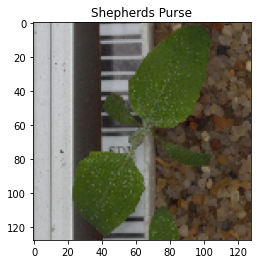

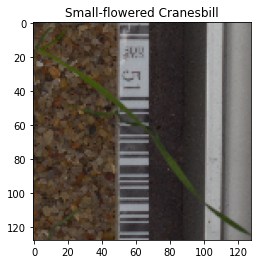

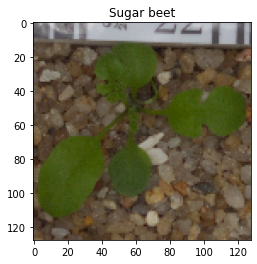

In [9]:
for i in range(0,12):
  plt.figure()
  for (img, label) in zip(train_img ,train_label):
    if (label[i]==1):
      plt.imshow(img)
      plt.title(categories[i])
      break


**Balancing the data**

In [10]:
#calculating number of images to be added to the category
num_of_img_to_add = []
for i in range(12):
  num_of_img_to_add.append(654 - (dict1[categories[i]]))
num_of_img_to_add = np.array(num_of_img_to_add)
print(num_of_img_to_add)
print(num_of_img_to_add.sum())

[391 264 367  43 433 179   0 433 138 423 148 269]
3088


In [11]:
#training set after data augmentation inititalisation
data_augmented_train_img = train_img
data_augmented_train_label = train_label

print(data_augmented_train_img.shape, data_augmented_train_label.shape)

(4760, 128, 128, 3) (4760, 12)


In [12]:
#creating new images based on the number of images required per category
#sharpening matrix
sharpening = np.array([ [-1, -1, -1],
                        [-1, 10, -1],
                        [-1, -1, -1]])
arr = []
labels = []

while (num_of_img_to_add.sum() > 0 ):
  for (img, label) in zip(train_img ,train_label):
    if (num_of_img_to_add[label.argmax()] > 0):
      temp_img = img
      #randomising various cv2 actions like rotating, flipping, sharpening
      random_nums = np.random.randint(0,2,5)
      #sharpening
      if (random_nums[0]):
        temp_img = cv2.filter2D(temp_img, -1, sharpening)
      #flipping
      if (random_nums[1]):
        temp_img = cv2.flip(temp_img, 1)
      #rotating
      if (random_nums[2]):
        temp_img = cv2.rotate(temp_img, rotateCode= cv2.ROTATE_180)
      if (random_nums[3]):
        temp_img = cv2.rotate(temp_img, rotateCode= cv2.ROTATE_90_COUNTERCLOCKWISE)
      if (random_nums[4]):
        temp_img = cv2.rotate(temp_img, rotateCode= cv2.ROTATE_90_CLOCKWISE)
      
      num_of_img_to_add[label.argmax()]-= 1
      #append to augmented dataset
      arr.append(temp_img)
      labels.append(label)

In [13]:
print(len(arr), len(labels), num_of_img_to_add)
# Extra 3088 images are augmented. And array of 12 zeroes indicate that there is no imbalance and all the classes have equal number of images

3088 3088 [0 0 0 0 0 0 0 0 0 0 0 0]


In [14]:
#using asarray to concatenate later
arr = np.asarray(arr)
labels = np.asarray(labels)
print(arr.shape,labels.shape)

(3088, 128, 128, 3) (3088, 12)


In [15]:
data_augmented_train_img = np.concatenate((train_img, arr),axis=0)
data_augmented_train_label = np.concatenate((train_label,labels),axis=0)

print(data_augmented_train_img.shape, data_augmented_train_label.shape)

(7848, 128, 128, 3) (7848, 12)


In the given dataset, there are 12 categories and the data is not balanced and the number of images for each class is different. Highest number of images per class was 654 and lowest was upto 221 images as seen earlier.
Now all the classes have 654 images by using data augmentation using rotations, flipping, sharpenening randomly.
So 654*12 = 7848.
So, the shape for data augmented train images is (7848,128,128,3) and for labels, it is (7848, 12) 

**Splitting into train and test**

In [16]:
random_seed = 0
X_train, X_test, Y_train, Y_test = train_test_split(data_augmented_train_img , data_augmented_train_label,test_size=0.1, random_state=random_seed)
X_valid, X_test_new, Y_valid, Y_test_new=train_test_split(data_augmented_train_img,data_augmented_train_label,test_size=0.5, random_state=random_seed)

In [17]:
print(X_train.shape, X_test.shape, Y_train.shape,Y_test.shape)

(7063, 128, 128, 3) (785, 128, 128, 3) (7063, 12) (785, 12)


**Inception model**

Model

In [18]:
base_model = InceptionV3(include_top= False, pooling='avg', weights="imagenet")

fine_tune_at=150
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable=False

model_1=keras.Sequential()
model_1.add(base_model)

#Overfitting. so dropout added
model_1.add(Dropout(0.4))
model_1.add(Flatten())

# Dense layer and l2 regularization
model_1.add(Dense(1024, activation='relu', kernel_regularizer='l2'))
# softmax with 12 outputs
model_1.add(Dense(12, activation='softmax'))

87924736/87910968 [==============================] - 1s 0us/step


Compile and fit

In [19]:
learning_rate = 0.001
adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
model_1.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [20]:
epochs = 100
batch_size = 128
#Early stopping
earlystopper = EarlyStopping(patience=10, verbose=0)
#Reduced lr plateau
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=10, min_lr=0.0001)
#Modelcheckpoint to save the best model
check=ModelCheckpoint('best_model_inception.h5', monitor='val_accuracy', mode='max', save_best_only=True)
history=model_1.fit(X_train, Y_train, validation_data= (X_valid, Y_valid), shuffle=True, epochs=epochs, batch_size=batch_size, callbacks=[earlystopper, lr_reduce,check], verbose=1)

Epoch 1/100
56/56 [==============================] - 68s 566ms/step - loss: 7.3064 - accuracy: 0.6637 - val_loss: 6.7334 - val_accuracy: 0.5166
Epoch 2/100
56/56 [==============================] - 26s 463ms/step - loss: 1.0644 - accuracy: 0.8857 - val_loss: 0.8629 - val_accuracy: 0.8252
Epoch 3/100
56/56 [==============================] - 31s 549ms/step - loss: 0.4288 - accuracy: 0.9213 - val_loss: 0.4331 - val_accuracy: 0.8815
Epoch 4/100
56/56 [==============================] - 26s 463ms/step - loss: 0.2493 - accuracy: 0.9401 - val_loss: 0.2281 - val_accuracy: 0.9472
Epoch 5/100
56/56 [==============================] - 26s 463ms/step - loss: 0.2820 - accuracy: 0.9431 - val_loss: 0.5716 - val_accuracy: 0.8405
Epoch 6/100
56/56 [==============================] - 26s 462ms/step - loss: 0.2842 - accuracy: 0.9473 - val_loss: 0.2783 - val_accuracy: 0.9442
Epoch 7/100
56/56 [==============================] - 26s 462ms/step - loss: 0.1518 - accuracy: 0.9725 - val_loss: 0.2330 - val_accuracy:

Loss, accuracy vs epochs

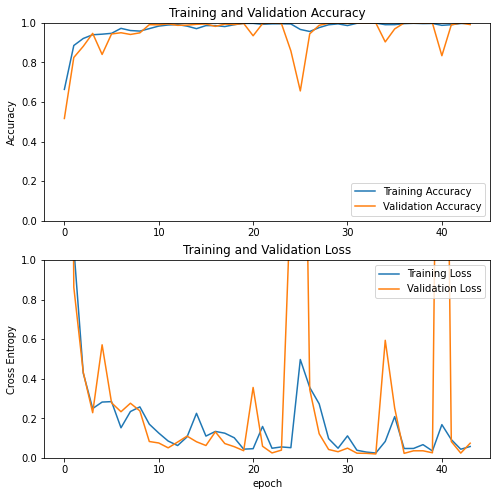

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Save model

In [22]:
saved_model_1 = load_model("best_model_inception.h5")

Confusion matrix and classification report

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = saved_model_1.predict(X_test_new)
y_pred_Classes = np.argmax(y_pred, axis = 1)
trueY = np.argmax(Y_test_new, axis = 1) 

# confusion matrix
cm = confusion_matrix(trueY, y_pred_Classes)
print(cm)
print(classification_report(trueY, y_pred_Classes))

[[516   0   0   0   0   1   0   0   0   1   5   0]
 [  0 326   0   0   0   0   0   1   0   0   0   0]
 [  0   0 359   0   1   1   0   1   3   0   0   0]
 [  0   0   0 284   2   0   0   0   0   0   0   0]
 [  0   0   0   0 511   0   0   0   4   0   0   1]
 [  1   0   1   0   0 192   0   0   0   0   2   0]
 [  0   0   0   0   0   0 112   0   0   0   0   0]
 [  0   0   0   0   0   0   0 362   0   1   0   0]
 [  1   0   0   0   1   0   0   0 314   0   0   1]
 [  0   0   0   0   0   0   0   0   0 464   0   0]
 [ 23   0   0   0   0   0   0   0   1   0 182   0]
 [  0   0   1   0   1   0   0   2  10   0   0 235]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       523
           1       1.00      1.00      1.00       327
           2       0.99      0.98      0.99       365
           3       1.00      0.99      1.00       286
           4       0.99      0.99      0.99       516
           5       0.99      0.98      0.98       196
        

**VGG 16**

Model

In [24]:
base_model_2 = VGG16(include_top=False, pooling='avg', weights="imagenet")
#fine tuning increased the accuracy, keeping trainable as True did not give good results
fine_tune_at=150
for layer in base_model_2.layers[:fine_tune_at]:
  layer.trainable=False
#base_model_2.trainable=True
model_2=Sequential()
model_2.add(base_model_2)
model_2.add(Flatten())
#model_2.add(Dropout(0.25))
# Add a new Dense layer to fully connect the node
model_2.add(Dense(512, activation='relu'))
model_2.add(Dropout(0.25))
model_2.add(Dense(512, activation='relu'))
model_2.add(Dropout(0.25))
# Add a new Dense layer to output 12 classes
# Initialize the weight with Xavier Normal Initialization
model_2.add(Dense(12, activation='softmax'))

58900480/58889256 [==============================] - 1s 0us/step


Compile and fit

In [25]:
learning_rate = 0.001
adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
model_2.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
epochs = 100
batch_size = 128
#Early stopping
earlystopper = EarlyStopping(patience=15, verbose=0)
#Reduced LR
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=10, min_lr=0.0001)
#ModelCheckpoint to save the best model
check=ModelCheckpoint('best_model_vgg16.h5', monitor='val_accuracy', mode='max', save_best_only=True)
history_2=model_2.fit(X_train, Y_train, validation_data= (X_valid, Y_valid), epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[earlystopper, lr_reduce, check], verbose=1)

Epoch 1/100
56/56 [==============================] - 53s 714ms/step - loss: 2.0403 - accuracy: 0.2980 - val_loss: 1.6227 - val_accuracy: 0.4289
Epoch 2/100
56/56 [==============================] - 27s 480ms/step - loss: 1.5438 - accuracy: 0.4569 - val_loss: 1.3566 - val_accuracy: 0.5341
Epoch 3/100
56/56 [==============================] - 27s 480ms/step - loss: 1.3369 - accuracy: 0.5326 - val_loss: 1.2298 - val_accuracy: 0.5535
Epoch 4/100
56/56 [==============================] - 27s 479ms/step - loss: 1.1949 - accuracy: 0.5843 - val_loss: 1.0591 - val_accuracy: 0.6300
Epoch 5/100
56/56 [==============================] - 27s 480ms/step - loss: 1.0873 - accuracy: 0.6149 - val_loss: 0.9732 - val_accuracy: 0.6611
Epoch 6/100
56/56 [==============================] - 27s 480ms/step - loss: 1.0080 - accuracy: 0.6418 - val_loss: 0.9174 - val_accuracy: 0.6641
Epoch 7/100
56/56 [==============================] - 27s 479ms/step - loss: 0.9615 - accuracy: 0.6584 - val_loss: 0.9092 - val_accuracy:

Loss and accuracy vs epoch

In [ ]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Save model

In [ ]:
saved_model_2 = load_model("best_model_vgg16.h5")

Confusion matrix and classification report

In [ ]:
y_pred = saved_model_2.predict(X_test_new)
y_pred_Classes = np.argmax(y_pred, axis = 1)
trueY = np.argmax(Y_test_new, axis = 1) 

# confusion matrix
cm = confusion_matrix(trueY, y_pred_Classes)
print(cm)
print(classification_report(trueY, y_pred_Classes))

**ResNet 50**

Model

In [ ]:
base_model_3 = ResNet50(include_top=False, weights="imagenet", pooling='avg')
#Model was giving very low accuracy hence trainable had to be set false for layers and after this the accuracy improved
for i in range(len(model_3.layers)-1):
  model_3.layers[i].trainable=False
#base_model_3.trainable=True
model_3=Sequential()
model_3.add(base_model_3)
model_3.add(Flatten())
model_3.add(Dropout(0.4))
# Add a new Dense layer to fully connect the node
model_3.add(Dense(1024, activation='relu'))
model_3.add(Dropout(0.2))
#Only one FC added as model was ovefitting a lot on having 2 FC
#model_3.add(Dense(512, activation='relu'))
#model_3.add(Dropout(0.2))
# Add a new Dense layer to output 12 classes
model_3.add(Dense(12, activation='softmax'))

Compile and fit

In [ ]:
learning_rate = 0.001
adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
model_3.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 150
batch_size = 128
earlystopper = EarlyStopping(patience=15, verbose=0)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=10, min_lr=0.0001)
check=ModelCheckpoint('best_model_resnet50.h5', monitor='val_accuracy', mode='max', save_best_only=True)
#Though ModelCheckPoint has been added but this saved model was not loaded because in resnet there was problem in printing confusion matrix
history_3=model_3.fit(X_train, Y_train, validation_data= (X_valid, Y_valid), epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[earlystopper, lr_reduce], verbose=1)

Loss and accuracy vs epoch

In [ ]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Save model

In [ ]:
saved_model_3 = load_model("best_model_resnet50.h5")

Confusion matrix and classification report

In [ ]:
y_pred =model_3.predict(X_test_new)
y_pred_Classes = np.argmax(y_pred, axis = 1)
trueY = np.argmax(Y_test_new, axis = 1) 

# confusion matrix
cm = confusion_matrix(trueY, y_pred_Classes)
print(cm)
print(classification_report(trueY, y_pred_Classes))